#  IMPORTING LIBRARIES

In [43]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque
import pandas as pd


# LOADING DATA

In [42]:
data = pd.read_csv('GOOG (4).csv')
data=np.array(data['Close'])
data=data[:850]
print(len(data))

850


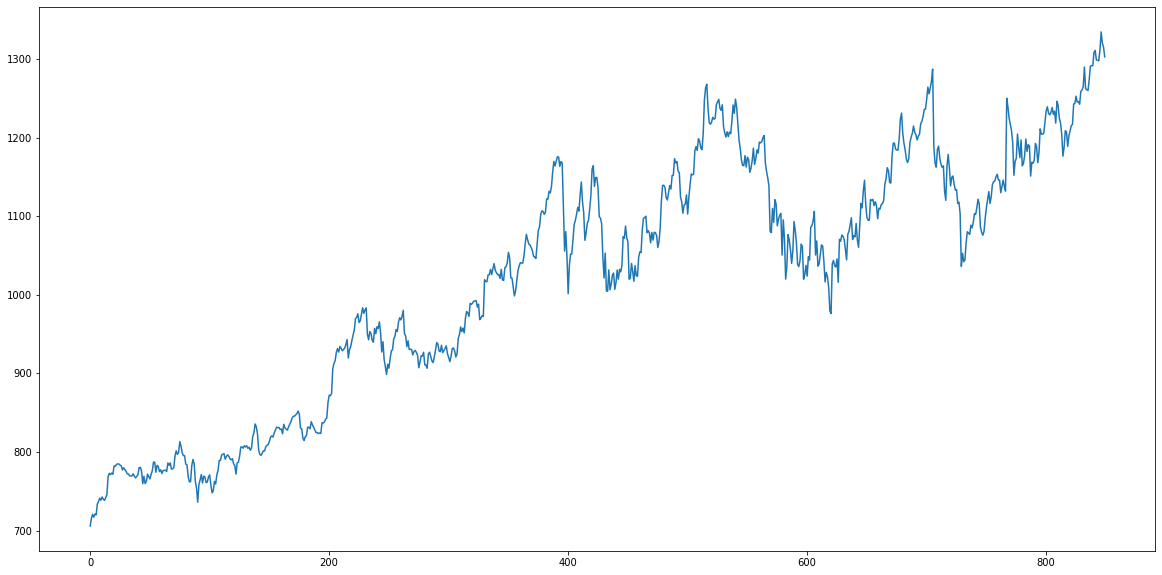

In [13]:
plt.figure(figsize=(20,10))
plt.plot(range(len(data)),data)
plt.show()

# AGENT CLASS

In [44]:
class Agent :
  def __init__(self,Money,MAXT, state_size,model_name=""):
        self.state_size = state_size+2 #(days + money + no. of transactions)
        self.action_size = 3 # buy sell hold
        self.memory = deque(maxlen=1000)
        self.inventory = 0. #no. of stock in possesion
        self.initial_money=Money 
        self.money=float(Money) #money agent have after every transaction
        self.money_before=float(Money) 
        self.transactions=0 
        self.max_t=MAXT
        self.is_eval = False #true when model is used for prediction
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._model() if model_name=="" else load_model(model_name)
  def _model(self):
        model = Sequential()
        model.add(Dense(units=16, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
        return model
  def act(self, state):
        if not self.is_eval and random.random()<= self.epsilon:
            s = " random " #just to check whether decisions are taken by model or randomly
            return random.randrange(self.action_size) , s
        input = np.reshape(state,(1,-1))
        options = self.model.predict(input)
        s = " not random "
        return np.argmax(options[0]) , s
  def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size+1, l):
            mini_batch.append(self.memory[i])
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            input = np.reshape(state,(1,-1))
            if not done:
                next_input=np.reshape(state,(1,-1))
                target = reward + self.gamma * np.amax(self.model.predict(next_input)[0])#Bellman Equation
            target_f = self.model.predict(input)
            target_f[0][action] = target
            self.model.fit(input, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# FUNCTIONS - BUY , SELL , GET_STATE

In [21]:
def formatPrice(n):
    return("-Rs." if n<0 else "Rs.")+"{0:.2f}".format(abs(n)) 
def sigmoid(x):
    return 1/(1+math.exp(-x))

def buy(agent,price):
    if(agent.transactions>=agent.max_t or agent.money<=0):
        return -1
    x=agent.money/(agent.max_t-agent.transactions)
    agent.money=agent.money-x
    stock=x/price
    agent.transactions+=1
    agent.inventory=stock+agent.inventory
    return 0
    
def sell(agent,price):
    if(agent.inventory==0) :
        return -1
    agent.money+=price*agent.inventory
    value =max(agent.initial_money,agent.money_before)
    reward=max(agent.money-value,0)
    agent.money_before=agent.money
    agent.inventory=0
    agent.transactions=0
    return reward

def get_state(agent ,data):
    value = np.reshape(data,(-1,1))
    ss=StandardScaler()
    value=ss.fit_transform(value)

    value=value[:,0]
    for i in range(len(value)):
        value[i]=sigmoid(value[i])
    value=np.append(value,[agent.transactions/agent.max_t,agent.money/(agent.money_before+1)])
    return np.array(value)


In [16]:
window_size = 8
episode_count = 6
Money=10000.0;
MAXT=5;


In [9]:
agent = Agent(Money,MAXT,window_size)

# TRAINING 

Episode 0/3
8    8000.0 1 not random 
9    6000.0 1 not random 
10    4000.0 1 not random 
11    2000.0 1 not random 
12    0.0 1 not random 
13    0.0 1 not random 
14    10025.91620314631 2 random 
15    8020.732962517048 1 not random 
16    6015.549721887786 1 not random 
17    6015.549721887786 0 random 
18    4010.366481258524 1 not random 
19    10116.161739102994 2 random 
20    8092.929391282395 1 not random 
21    6069.697043461796 1 random 
22    4046.464695641197 1 not random 
23    2023.2323478205985 1 random 
24    0.0 1 not random 
25    0.0 1 random 
26    0.0 1 not random 
27    0.0 1 not random 
28    0.0 1 not random 
29    0.0 1 not random 
30    0.0 1 not random 
31    0.0 1 not random 
32    10003.111682873632 2 random 
33    10003.111682873632 2 random 
34    8002.489346298906 1 not random 
35    6001.867009724179 1 not random 
36    4001.244673149453 1 not random 
37    2000.6223365747264 1 not random 
38    0.0 1 not random 
39    0.0 1 not random 
40    0.0 1 n

233    8615.410532557491 1 not random 
234    6461.557899418118 1 not random 
235    4307.705266278745 1 not random 
236    10783.362356359714 2 not random 
237    8626.689885087771 1 random 
238    8626.689885087771 0 random 
239    10817.830292618773 2 not random 
240    8654.264234095019 1 not random 
241    10837.903999193122 2 not random 
242    10837.903999193122 2 random 
243    10837.903999193122 0 random 
244    8670.323199354498 1 not random 
245    6502.742399515873 1 not random 
246    4335.161599677249 1 not random 
247    2167.5807998386244 1 not random 
248    0.0 1 not random 
249    10483.720893654407 2 not random 
250    8386.976714923525 1 not random 
251    6290.232536192643 1 not random 
252    10527.062596764528 2 not random 
253    10527.062596764528 2 not random 
254    8421.650077411623 1 not random 
255    10558.165335340376 2 not random 
256    8446.532268272302 1 not random 
257    10577.851298019854 2 not random 
258    8462.281038415884 1 random 
259    10

444    11102.854973094514 2 not random 
445    8882.28397847561 1 not random 
446    11121.646042653007 2 not random 
447    11121.646042653007 2 not random 
448    8897.316834122405 1 random 
449    11154.054083602894 2 not random 
450    8923.243266882315 1 not random 
451    6692.432450161736 1 not random 
452    4461.6216334411565 1 not random 
453    10952.324666721517 2 not random 
454    8761.859733377214 1 not random 
455    6571.394800032911 1 not random 
456    10877.444357785407 2 not random 
457    10877.444357785407 0 random 
458    8701.955486228326 1 not random 
459    10876.04263516798 2 random 
460    10876.04263516798 2 not random 
461    10876.04263516798 2 not random 
462    8700.834108134384 1 not random 
463    10935.58729436601 2 not random 
464    10935.58729436601 2 not random 
465    8748.469835492808 1 not random 
466    10939.450567900192 2 not random 
467    8751.560454320153 1 not random 
468    6563.670340740115 1 random 
469    10931.721397642885 2 not r

654    10809.580573599616 2 not random 
655    10809.580573599616 2 not random 
656    8647.664458879693 1 not random 
657    6485.748344159771 1 not random 
658    10813.118157856676 2 not random 
659    8650.49452628534 1 not random 
660    6487.870894714005 1 not random 
661    10832.875655084503 2 not random 
662    8666.300524067603 1 not random 
663    10844.065878689365 2 not random 
664    8675.252702951493 1 not random 
665    10851.586416100356 2 not random 
666    8681.269132880285 1 not random 
667    10864.540069398794 2 not random 
668    8691.632055519036 1 not random 
669    6518.724041639277 1 not random 
670    4345.816027759518 1 not random 
671    10796.657617259321 2 not random 
672    10796.657617259321 2 not random 
673    8637.326093807456 1 not random 
674    10796.87477196666 2 not random 
675    8637.499817573329 1 not random 
676    6478.124863179997 1 not random 
677    10794.160551289988 2 not random 
678    8635.32844103199 1 not random 
679    10839.3954

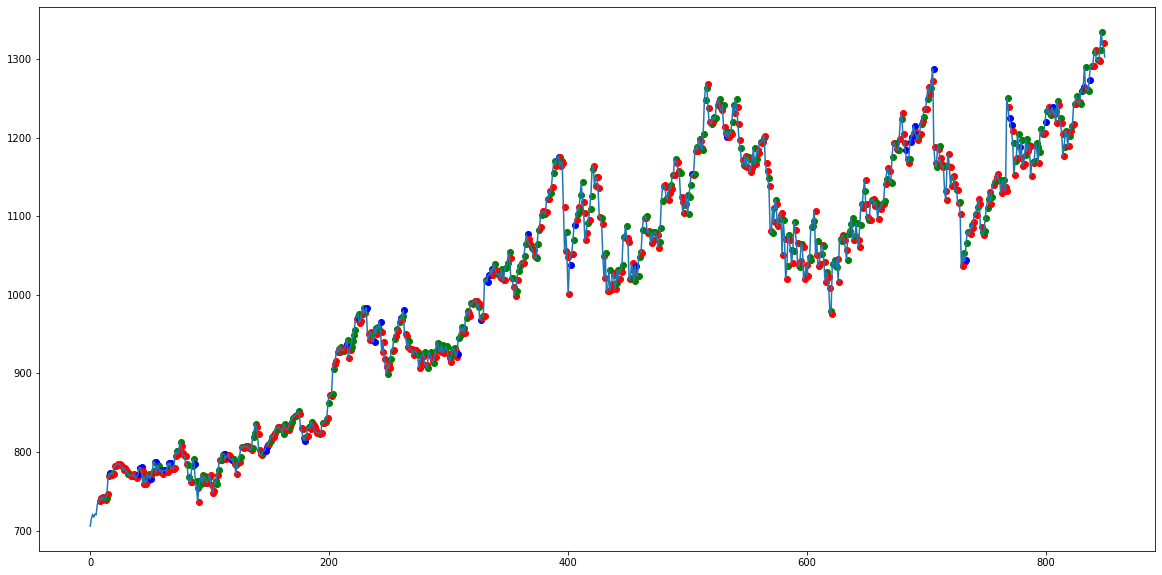

Episode 1/3
8    10000.0 2 not random 
9    8000.0 1 not random 
10    8000.0 0 not random 
11    8000.0 0 not random 
12    6000.0 1 not random 
13    9988.875599042249 2 not random 
14    7991.100479233799 1 not random 
15    10000.025544278073 2 not random 
16    10000.025544278073 2 not random 
17    10000.025544278073 0 not random 
18    10000.025544278073 0 random 
19    8000.020435422458 1 not random 
20    6000.015326566843 1 not random 
21    10050.910468221206 2 not random 
22    8040.728374576965 1 not random 
23    10057.338854388094 2 not random 
24    8045.871083510475 1 not random 
25    6034.403312632856 1 not random 
26    6034.403312632856 0 not random 
27    10045.420359045424 2 not random 
28    8036.336287236339 1 not random 
29    6027.252215427254 1 not random 
30    10040.14280068881 2 not random 
31    8032.114240551049 1 not random 
32    6024.085680413287 1 not random 
33    10031.311562591416 2 not random 
34    8025.0492500731325 1 not random 
35    6018.78

220    8266.910638904854 1 not random 
221    10348.910706641589 2 not random 
222    10348.910706641589 2 not random 
223    10348.910706641589 0 not random 
224    8279.12856531327 1 not random 
225    8279.12856531327 0 not random 
226    6209.346423984953 1 not random 
227    6209.346423984953 0 not random 
228    10380.748993747708 2 not random 
229    10380.748993747708 0 not random 
230    8304.599194998165 1 not random 
231    10390.03943291208 2 not random 
232    8312.031546329665 1 not random 
233    6234.0236597472485 1 not random 
234    4156.015773164832 1 not random 
235    10357.577246696066 2 not random 
236    8286.061797356853 1 not random 
237    6214.54634801764 1 not random 
238    6214.54634801764 0 not random 
239    10405.086035672848 2 not random 
240    8324.068828538278 1 not random 
241    10424.393848636366 2 not random 
242    8339.515078909093 1 not random 
243    10442.909838817803 2 not random 
244    8354.327871054242 1 not random 
245    6265.7459032

429    10580.227876212279 0 not random 
430    8464.182300969824 1 not random 
431    6348.136725727368 1 not random 
432    6348.136725727368 0 not random 
433    6348.136725727368 0 not random 
434    6348.136725727368 0 not random 
435    6348.136725727368 0 not random 
436    6348.136725727368 0 not random 
437    6348.136725727368 0 not random 
438    6348.136725727368 0 not random 
439    6348.136725727368 0 not random 
440    4232.091150484912 1 not random 
441    4232.091150484912 0 not random 
442    4232.091150484912 0 not random 
443    4232.091150484912 0 not random 
444    10622.98521325198 2 not random 
445    8498.388170601585 1 not random 
446    6373.791127951189 1 not random 
447    10789.701627510687 2 not random 
448    8631.76130200855 1 not random 
449    6473.820976506413 1 not random 
450    4315.880651004276 1 not random 
451    2157.940325502138 1 not random 
452    0.0 1 not random 
453    0.0 1 not random 
454    10551.475509814576 2 not random 
455    8441.

645    11869.246183721838 2 not random 
646    11869.246183721838 2 not random 
647    9495.396946977471 1 not random 
648    11916.37064196071 2 not random 
649    11916.37064196071 2 not random 
650    9533.096513568567 1 not random 
651    7149.822385176425 1 not random 
652    4766.548256784283 1 not random 
653    11865.025364889261 2 not random 
654    9492.020291911409 1 not random 
655    11862.464886542322 2 not random 
656    9489.971909233858 1 not random 
657    7117.478931925394 1 not random 
658    11866.34704170522 2 not random 
659    9493.077633364175 1 not random 
660    7119.808225023131 1 not random 
661    4746.538816682087 1 not random 
662    11881.790480504871 2 not random 
663    9505.432384403897 1 not random 
664    11883.751107515503 2 not random 
665    9507.000886012403 1 not random 
666    11928.466798685471 2 not random 
667    11928.466798685471 2 not random 
668    9542.773438948378 1 not random 
669    11919.905534318515 2 not random 
670    9535.9244

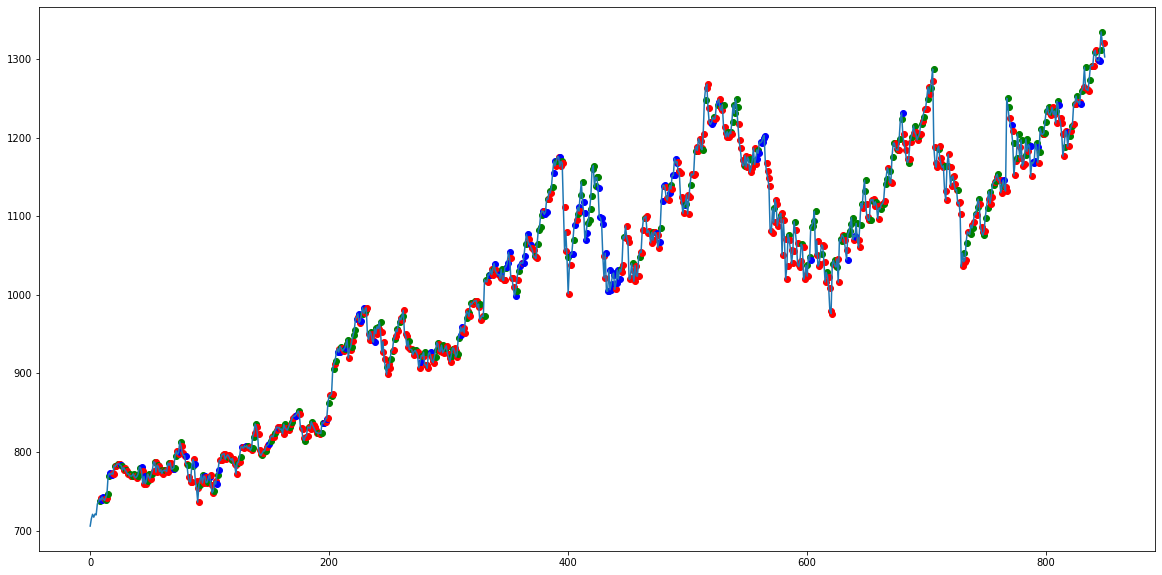

Episode 2/3
8    10000.0 2 not random 
9    8000.0 1 not random 
10    8000.0 0 not random 
11    8000.0 0 not random 
12    6000.0 1 not random 
13    6000.0 0 not random 
14    10006.972185203012 2 not random 
15    10006.972185203012 2 not random 
16    10006.972185203012 2 not random 
17    10006.972185203012 0 not random 
18    8005.57774816241 1 not random 
19    8005.57774816241 0 not random 
20    6004.1833111218075 1 not random 
21    10063.433183878084 2 not random 
22    8050.746547102467 1 not random 
23    10069.869579354414 2 not random 
24    8055.895663483531 1 not random 
25    6041.921747612649 1 not random 
26    6041.921747612649 0 not random 
27    4027.947831741766 1 not random 
28    2013.973915870883 1 not random 
29    10045.616597247541 2 not random 
30    8036.493277798033 1 not random 
31    6027.369958348525 1 not random 
32    4018.246638899017 1 not random 
33    4018.246638899017 0 not random 
34    2009.1233194495085 1 not random 
35    10001.4092025024

230    6323.067179673525 1 not random 
231    4215.37811978235 1 not random 
232    2107.689059891175 1 not random 
233    0.0 1 not random 
234    0.0 1 not random 
235    0.0 1 not random 
236    0.0 1 not random 
237    0.0 1 not random 
238    0.0 1 not random 
239    0.0 1 not random 
240    0.0 1 not random 
241    0.0 0 not random 
242    0.0 0 not random 
243    0.0 0 not random 
244    0.0 1 not random 
245    0.0 1 not random 
246    0.0 1 not random 
247    0.0 1 not random 
248    0.0 1 not random 
249    0.0 1 not random 
250    0.0 1 not random 
251    0.0 1 not random 
252    0.0 0 not random 
253    0.0 0 not random 
254    0.0 0 not random 
255    0.0 0 not random 
256    0.0 0 not random 
257    0.0 1 not random 
258    0.0 1 not random 
259    0.0 1 not random 
260    0.0 1 random 
261    0.0 1 not random 
262    0.0 1 not random 
263    0.0 1 not random 
264    0.0 1 not random 
265    0.0 1 not random 
266    0.0 1 not random 
267    0.0 1 not random 
268    0.0 1 

530    12265.40194304394 2 not random 
531    9812.321554435151 1 not random 
532    7359.241165826364 1 not random 
533    4906.160777217576 1 not random 
534    2453.080388608788 1 not random 
535    0.0 1 not random 
536    12276.642805099786 2 not random 
537    9821.31424407983 1 not random 
538    12307.747447305974 2 not random 
539    12307.747447305974 2 not random 
540    9846.197957844779 1 not random 
541    12344.036432321222 2 not random 
542    9875.229145856978 1 not random 
543    7406.4218593927335 1 not random 
544    4937.614572928489 1 not random 
545    2468.8072864642445 1 not random 
546    0.0 1 not random 
547    11962.551398295405 2 not random 
548    9570.041118636324 1 not random 
549    7177.530838977243 1 not random 
550    4785.020559318162 1 not random 
551    12006.125872409193 2 not random 
552    9604.900697927354 1 not random 
553    7203.675523445516 1 not random 
554    4802.450348963677 1 not random 
555    12054.825733870506 2 not random 
556   

742    12261.929686912168 2 not random 
743    12261.929686912168 0 not random 
744    12261.929686912168 0 not random 
745    9809.543749529734 1 not random 
746    7357.1578121473 1 not random 
747    4904.771874764867 1 not random 
748    2452.3859373824334 1 not random 
749    12187.2506612484 2 not random 
750    9749.80052899872 1 not random 
751    12216.77678506165 2 not random 
752    9773.42142804932 1 not random 
753    12238.583533146266 2 not random 
754    9790.866826517013 1 not random 
755    7343.1501198877595 1 not random 
756    12325.546806230226 2 not random 
757    9860.437444984182 1 not random 
758    7395.328083738136 1 not random 
759    12350.466272954363 2 not random 
760    9880.37301836349 1 not random 
761    7410.279763772618 1 not random 
762    4940.186509181745 1 not random 
763    2470.0932545908727 1 not random 
764    12299.035898341088 2 not random 
765    9839.22871867287 1 not random 
766    7379.421539004652 1 not random 
767    4919.6143593364

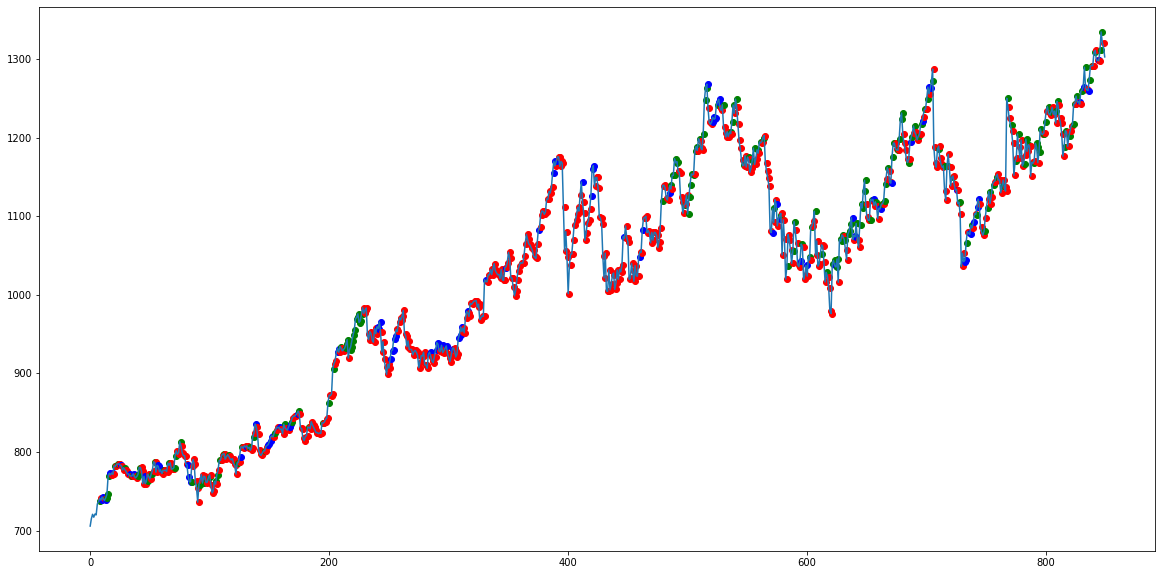

Episode 3/3
8    10000.0 2 not random 
9    10000.0 0 not random 
10    8000.0 1 not random 
11    8000.0 0 not random 
12    6000.0 1 not random 
13    4000.0 1 not random 
14    10022.982880964093 2 not random 
15    10022.982880964093 2 not random 
16    10022.982880964093 2 not random 
17    10022.982880964093 0 not random 
18    8018.386304771275 1 not random 
19    8018.386304771275 0 not random 
20    6013.789728578457 1 not random 
21    10079.534214643143 2 not random 
22    8063.627371714514 1 not random 
23    8063.627371714514 0 not random 
24    8063.627371714514 0 not random 
25    6047.720528785885 1 not random 
26    6047.720528785885 0 not random 
27    4031.813685857257 1 not random 
28    2015.9068429286285 1 not random 
29    10062.741877084707 2 not random 
30    8050.193501667765 1 not random 
31    6037.6451262508235 1 not random 
32    4025.0967508338827 1 not random 
33    2012.5483754169413 1 not random 
34    2012.5483754169413 0 not random 
35    10012.10077

231    10693.983435834483 0 not random 
232    10693.983435834483 0 not random 
233    8555.186748667587 1 not random 
234    6416.3900615006905 1 not random 
235    4277.593374333794 1 not random 
236    2138.796687166897 1 not random 
237    0.0 1 not random 
238    10603.279279944412 2 not random 
239    8482.62342395553 1 not random 
240    6361.967567966648 1 not random 
241    10627.56227719688 2 not random 
242    8502.049821757504 1 not random 
243    10646.439138684891 2 not random 
244    8517.151310947913 1 not random 
245    6387.863483210935 1 not random 
246    4258.575655473956 1 not random 
247    2129.287827736978 1 not random 
248    0.0 1 not random 
249    0.0 0 not random 
250    0.0 0 not random 
251    0.0 0 not random 
252    10526.439647498366 2 not random 
253    10526.439647498366 0 not random 
254    10526.439647498366 0 not random 
255    10526.439647498366 0 not random 
256    10526.439647498366 0 not random 
257    10526.439647498366 0 not random 
258    

451    6006.939508618259 1 random 
452    4004.62633907884 1 not random 
453    2002.31316953942 1 not random 
454    0.0 1 not random 
455    0.0 1 not random 
456    0.0 1 not random 
457    9948.893600253332 2 not random 
458    7959.1148802026655 1 not random 
459    5969.336160151999 1 not random 
460    10042.782018452017 2 not random 
461    10042.782018452017 0 not random 
462    8034.2256147616135 1 not random 
463    10097.764704043484 2 not random 
464    10097.764704043484 0 not random 
465    8078.211763234787 1 not random 
466    8078.211763234787 0 not random 
467    6058.65882242609 1 not random 
468    4039.1058816173936 1 not random 
469    2019.5529408086968 1 not random 
470    0.0 1 not random 
471    0.0 0 not random 
472    0.0 1 not random 
473    10087.8991343912 2 not random 
474    8070.31930751296 1 not random 
475    6052.73948063472 1 not random 
476    4035.15965375648 1 not random 
477    2017.57982687824 1 not random 
478    10195.570499276055 2 not ran

670    8900.47254890264 1 not random 
671    6675.354411676981 1 not random 
672    11253.902744414081 2 not random 
673    11253.902744414081 0 random 
674    11253.902744414081 0 not random 
675    9003.122195531265 1 not random 
676    9003.122195531265 0 not random 
677    9003.122195531265 0 not random 
678    11279.152810422185 2 not random 
679    11279.152810422185 2 not random 
680    11279.152810422185 2 not random 
681    9023.322248337749 1 not random 
682    6767.491686253312 1 not random 
683    4511.661124168875 1 not random 
684    2255.8305620844376 1 not random 
685    11124.123442912114 2 not random 
686    8899.298754329691 1 not random 
687    8899.298754329691 0 not random 
688    11175.66189266708 2 not random 
689    11175.66189266708 0 not random 
690    11175.66189266708 0 not random 
691    8940.529514133665 1 not random 
692    6705.3971356002485 1 not random 
693    4470.264757066832 1 not random 
694    11172.469945960802 2 not random 
695    8937.97595676

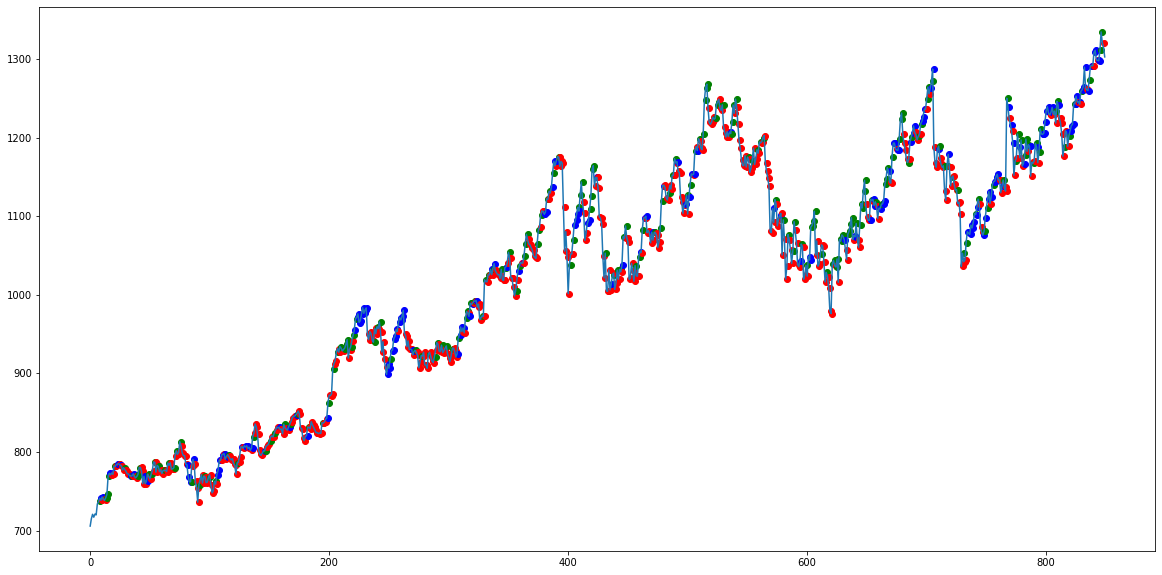

INFO:tensorflow:Assets written to: lastplease\assets


In [18]:
agent.is_eval=False
episode_count = 4
l = len(data)
agent.max_t=5
batch_size = 32
for e in range(episode_count):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = get_state(agent,data[0:window_size])
    agent.money=Money
    code ={0:'b',1:'r',2:'g'}
    decisions=[]
    actions=[0,0,0]
    agent.inventory=0.
    agent.transactions=0.
    for t in range(window_size,l-1):
        action , s = agent.act(state)
        decisions.append(code[action])
        reward = 0
        if action==0:
            actions[0]=actions[0]+1
            actions[1]=0
            actions[2]=0
            reward = -1*(actions[0])
        if action == 1: # buy
            reward=buy(agent,float(data[t-1]))
            
            actions[1]=actions[1]+1
            actions[0]=0
            actions[2]=0
            reward=reward*actions[1]
        elif action == 2 :
            reward=sell(agent,data[t-1])
            actions[2]=actions[2]+1
            actions[1]=0
            actions[0]=0
            if reward <0:
                  reward = -1*(2**(actions[2]))
        next_state = get_state(agent,data[t-window_size+1:t+1])
        done = True if t == l - 2 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            agent.money+=agent.inventory*float(data[t])
            print("--------------------------------")
            print("Total Profit: " + formatPrice(agent.money-Money))
            print("--------------------------------")
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)
    
        print(str(t)+ "    "+str(agent.money)+" " +str(action)+s)
    plt.figure(figsize=(20,10))
    for t in range(window_size,l-1):
        plt.scatter(t,data[t-1],color=decisions[t-window_size])
    plt.plot(range(len(data)),data)
    plt.show()
    agent.memory.clear()
    
    
agent.model.save('lastplease')

# TESTING

In [45]:
stocks=['_GOOG_','_AAPL_','_AMZN_','_TSLA_']

--------------------------------
Total Profit: Rs.2990.64
--------------------------------


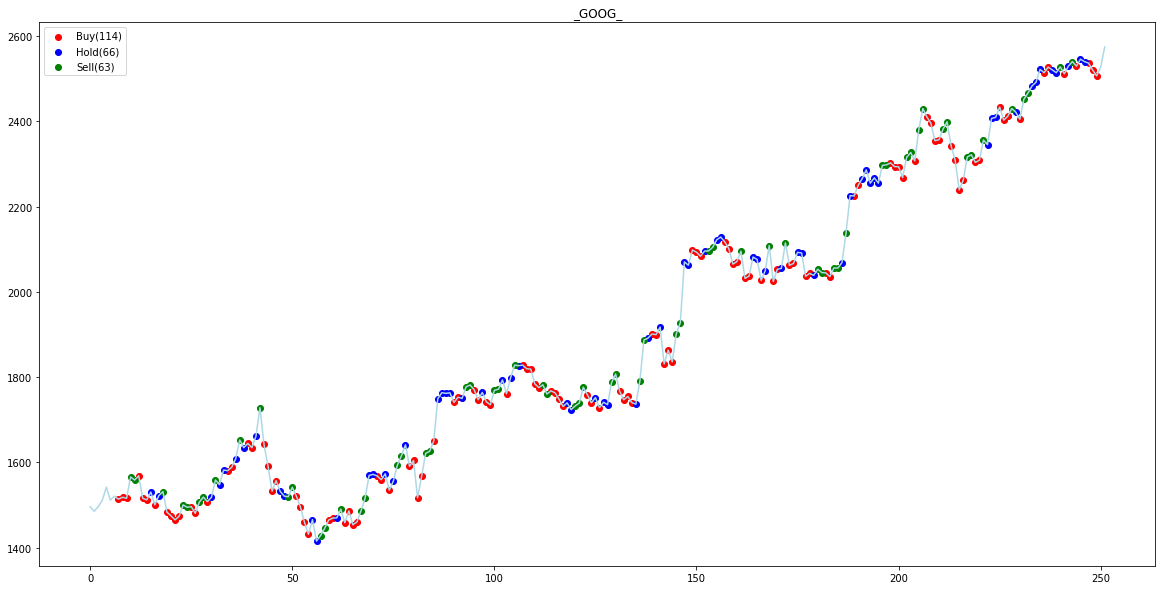

--------------------------------
Total Profit: Rs.1988.50
--------------------------------


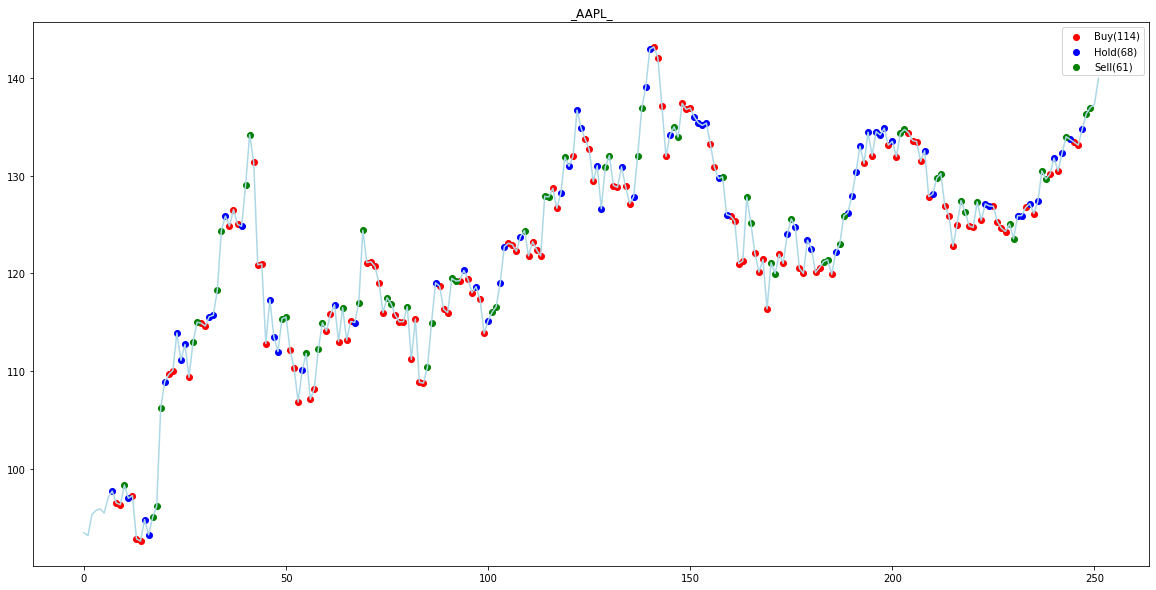

--------------------------------
Total Profit: Rs.2307.10
--------------------------------


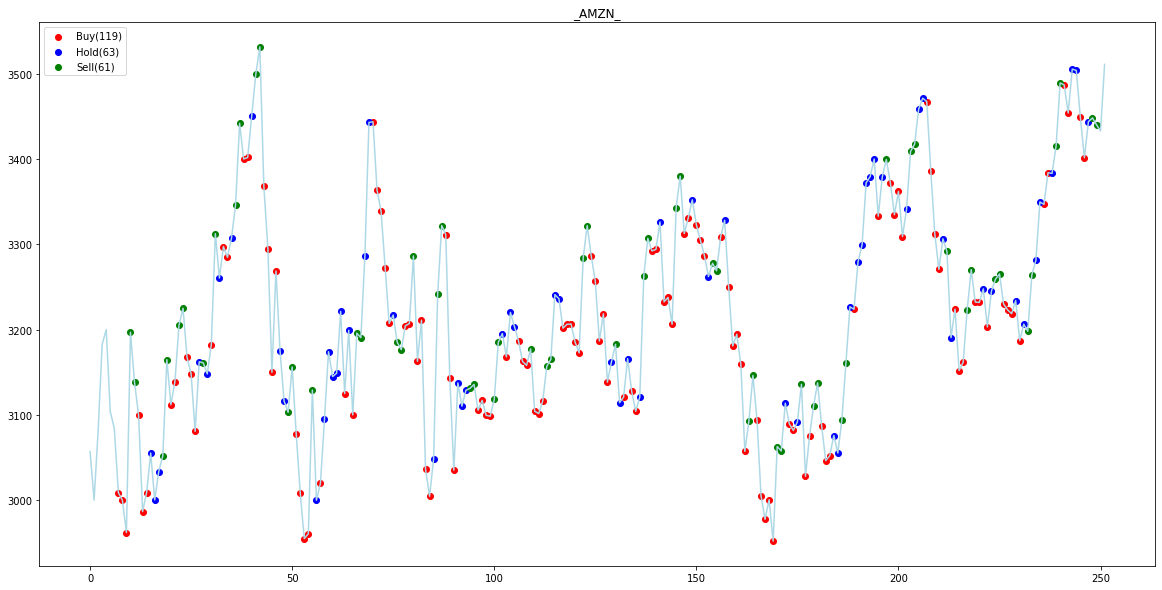

--------------------------------
Total Profit: Rs.3876.65
--------------------------------


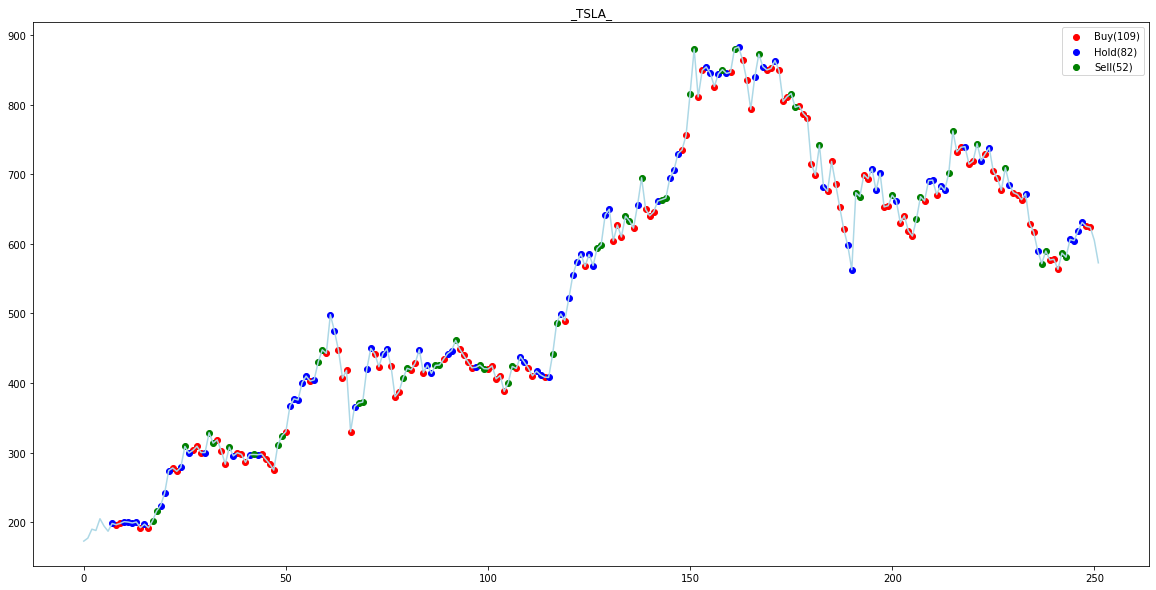

In [35]:
for stock in stocks:
    test = pd.read_csv(stock+'.csv')
    l = len(test)
    agent.money=Money
    agent.inventory=0.
    agent.is_eval=True
    agent.transactions=0.
    test=np.array(test['Close'])
    state=get_state(agent,test[0:window_size])
    decisions={0:[],1:[],2:[]}
    for t in range(window_size,l-1):
            action,_ = agent.act(state)
            next_state = get_state(agent,test[t-window_size+1:t+1])
            decisions[action].append([t-1,test[t-1]])
            if action == 1: # buy
                buy(agent,float(test[t-1]))
            elif action == 2 :
                sell(agent,test[t-1])
            done = True if t == l - 2 else False
            state = next_state
            if done:
                agent.money+=agent.inventory*float(test[t])
                print("--------------------------------")
                print("Total Profit: " + formatPrice(agent.money-Money))
                print("--------------------------------")
    h = np.array(decisions[0])
    b = np.array(decisions[1])
    s = np.array(decisions[2])
    
    plt.figure(figsize=(20,10))
    plt.title(stock)
    Buy=plt.scatter(b[:,0],b[:,1],color='r')
    Hold=plt.scatter(h[:,0],h[:,1],color='b')
    Sell=plt.scatter(s[:,0],s[:,1],color='g')
    plt.plot(range(len(test)),test,color='lightblue')
    plt.legend(handles = [Buy,Hold,Sell], 
               labels  = ['Buy'+'('+str(len(b))+')', 'Hold'+'('+str(len(h))+')', 'Sell'+'('+str(len(s))+')'])
    plt.show()

# TESTING WITH VALUE CHANGE

In [40]:
Money=20000 
agent.max_t=7

--------------------------------
Total Profit: Rs.4595.75
--------------------------------


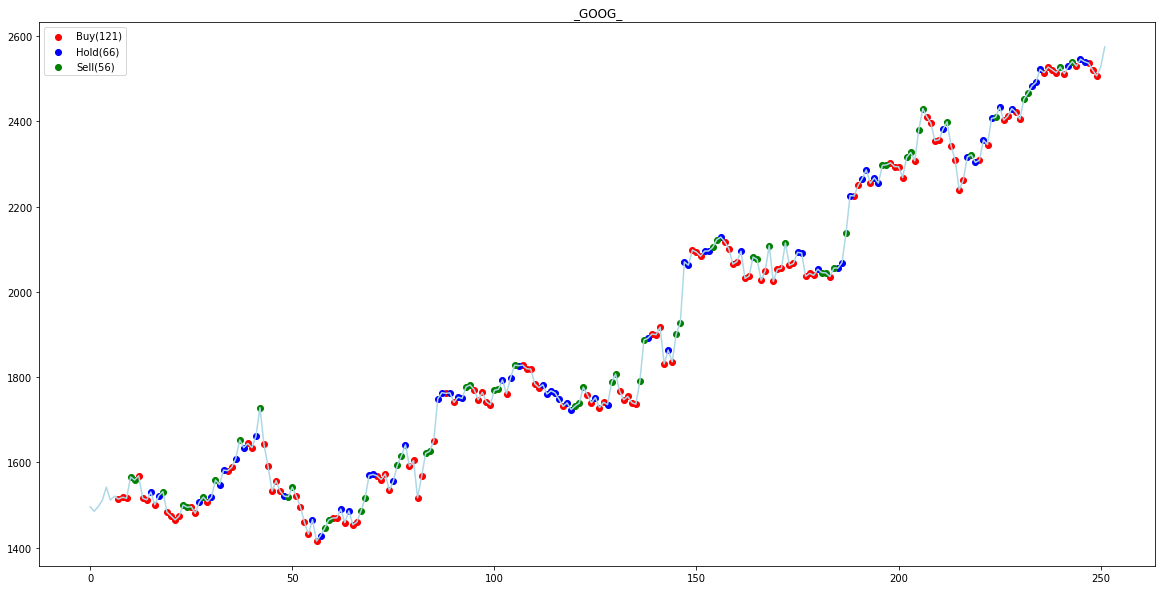

--------------------------------
Total Profit: Rs.3668.16
--------------------------------


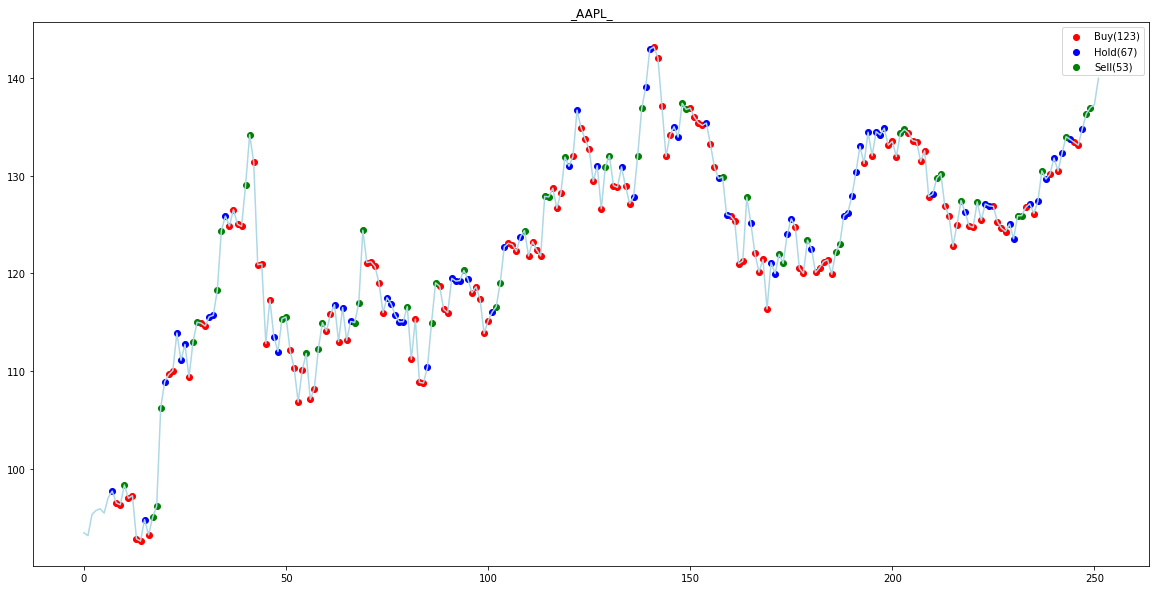

--------------------------------
Total Profit: Rs.3576.94
--------------------------------


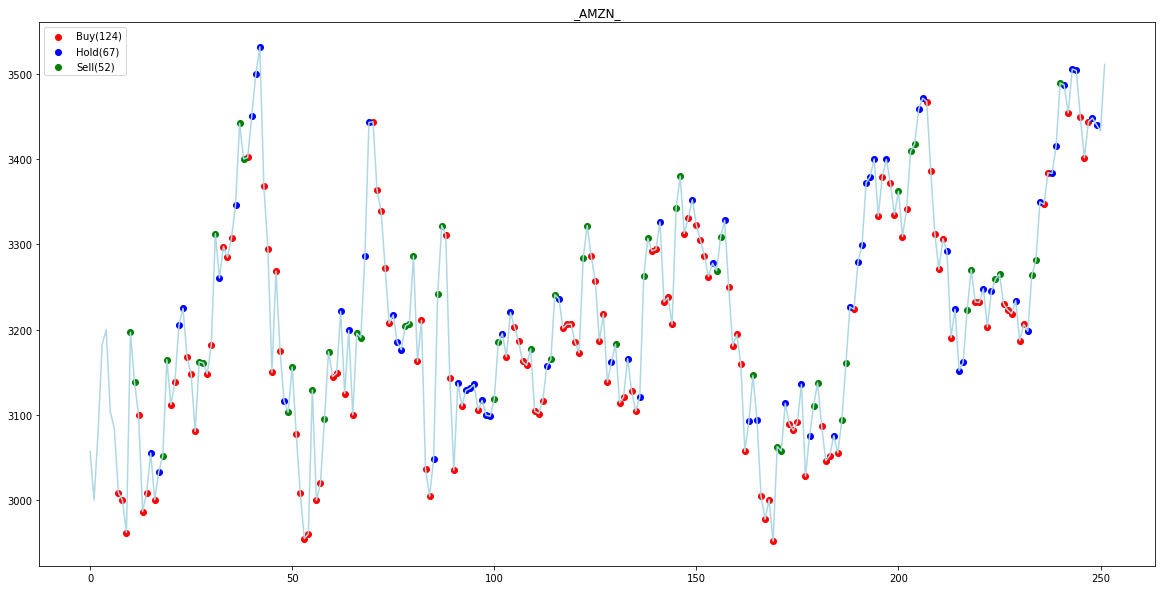

--------------------------------
Total Profit: Rs.11617.79
--------------------------------


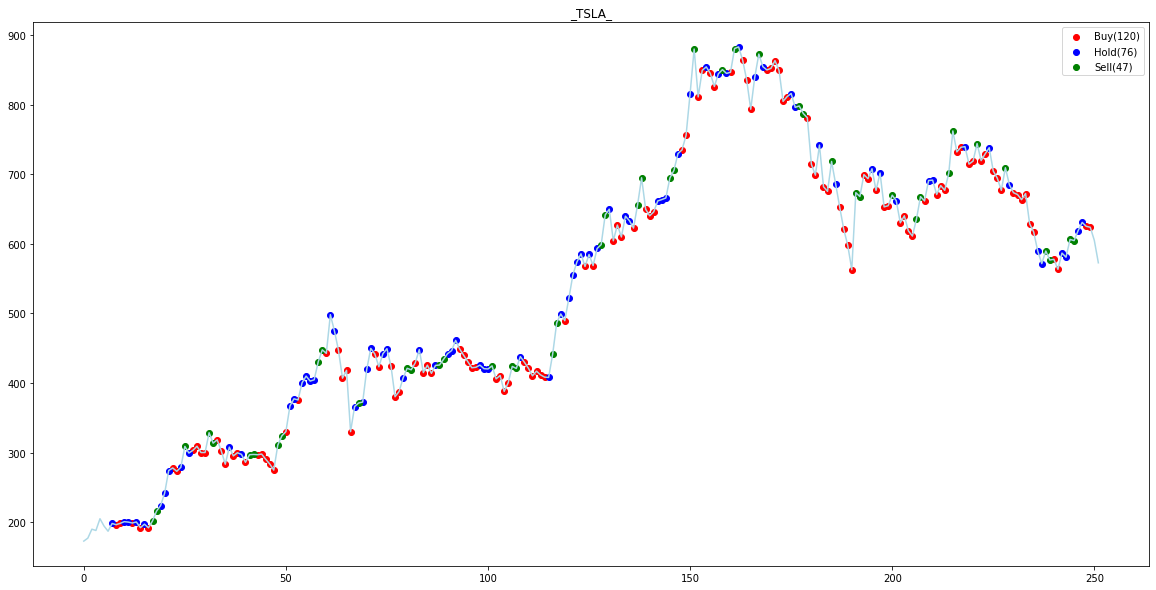

In [41]:
for stock in stocks:
    test = pd.read_csv(stock+'.csv')
    l = len(test)
    agent.money=Money
    agent.inventory=0.
    agent.is_eval=True
    agent.transactions=0.
    test=np.array(test['Close'])
    state=get_state(agent,test[0:window_size])
    decisions={0:[],1:[],2:[]}
    for t in range(window_size,l-1):
            action,_ = agent.act(state)
            next_state = get_state(agent,test[t-window_size+1:t+1])
            decisions[action].append([t-1,test[t-1]])
            if action == 1: # buy
                buy(agent,float(test[t-1]))
            elif action == 2 :
                sell(agent,test[t-1])
            done = True if t == l - 2 else False
            state = next_state
            if done:
                agent.money+=agent.inventory*float(test[t])
                print("--------------------------------")
                print("Total Profit: " + formatPrice(agent.money-Money))
                print("--------------------------------")
    h = np.array(decisions[0])
    b = np.array(decisions[1])
    s = np.array(decisions[2])
    
    plt.figure(figsize=(20,10))
    plt.title(stock)
    Buy=plt.scatter(b[:,0],b[:,1],color='r')
    Hold=plt.scatter(h[:,0],h[:,1],color='b')
    Sell=plt.scatter(s[:,0],s[:,1],color='g')
    plt.plot(range(len(test)),test,color='lightblue')
    plt.legend(handles = [Buy,Hold,Sell], 
               labels  = ['Buy'+'('+str(len(b))+')', 'Hold'+'('+str(len(h))+')', 'Sell'+'('+str(len(s))+')'])
    plt.show()